[View in Colaboratory](https://colab.research.google.com/github/ocalla22/kaggle/blob/master/Keras_MNist.ipynb)

#MNist Digit-Recogniser
1. Hello Colaboratory - Colaboratory setup
2. Hello Data - Data Exploration
3. Hello Keras -  Developing machine learning models for Digit Recognition using Keras and the SKLearn API
4. Hello Deployment - Predicting Kaggle Dataset and downloading results!
5. Hello Documentation - Links to supporting documentation for packages and tools used

**Previously**

97% Accuracy achieved using an MLP from SKLearn. It was fast and easy to train and has  an affinity for learning with more data.
In this iteration we explore different Neural Net architectures and settings, to improve on the previous iterations results.

**Next**

Take the ideal general architecture and add more advanced and subtle changes to maximise performance.

**End Goal**

The goal is to define a generalisable recipe for classification problems from Kaggle with Keras and  SKLearn API on Colaboratory. The user can plug and play different nueral net architectures, data and searchspaces and experiment parameters. The notebook executes remotely; freeing up the developers local resources for other processes. 

**First Pass **

The notebook gives an quick but insightful glimpse towards promising models and methods for this problem. It serves as a reasonable "first-pass" for the problem; where a more specialised methodology can be adopted based on its findings.

## 1. Hello Colaboratory
The following section is to setup Colaboratory Environment

Jupyter notebooks are very popular. They blend the interactivity of CLI with the automative power of batch interface. Their document oriented design promotes readable/self-documenting code necesary for transparent logical workflows. Overall its a flexible and light IDE.

[Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb) is Google's free cloud service that mimics Jupyter Notebooks. One of the big perks of Colaboratory is the free GPU runtime for 12 hour slots. This makes it a very nice environment to practice deep learning with a TensorFlow backend.

### Test GPU Runtime
- Runtime > Change runtime type > Hardware Accelerator : GPU


In [1]:
#High Performance Computation Engine.
import tensorflow as tf

#Test for GPU presence.
tf.test.gpu_device_name()

'/device:GPU:0'

### Environment Setup
Colaboratory is run remotely and environments are not persistent. However, setup can be easily scripted in the notebook. Generally, it's preffered to keep setup logic out of the notebooks; its prettier. However it keeps colaboratory notebooks accessable for their many users.

####Setup Drives API and Kaggle API
Before Proceeding!

In Browser:
1. Go to [Kaggle](https://www.kaggle.com/)
2. My Account > API > create new API token  (Downloads token as kaggle.json)
3. Go to [Drives](https://drive.google.com/drive/my-drive)
4. New > File Upload > Downloads > kaggle.json (The token we just downloaded)

In [0]:
#Install Kaggle API
!pip install kaggle -q

#Make Data Folder
!mkdir data

In [3]:
#Python Core Modules
from io import FileIO
from os import makedirs, path, chmod

#Google Colaboratpry API
from google.colab import auth

#Google Client APIs
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload

# Authenticate Colaboratory user 
auth.authenticate_user()

#Build Google Client API
drive_service = build('drive', 'v3')

#Retrieve kaggle.json from Drives and unpack results
results = drive_service.files().list(
    q="name = 'kaggle.json'", 
    fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

#Make dirs and file (binary format) for token
filename = "/content/.kaggle/kaggle.json"
makedirs(path.dirname(filename), exist_ok=True)
fh = FileIO(filename, 'wb')

#Create request object and a downloader
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
downloader = MediaIoBaseDownload(fh, request)

#Download object in chunks
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))

#Alter file permissions to Owner:Read-Write
chmod(filename, 600)

Download 100%.


###Get Kaggle Dataset
1. Find the competition/dataset in Kaggle.
2. Join the competition.
3. Copy the CLI command for Kaggle API.

In [4]:
#Paste Kaggle API Command here!
#kaggle competitions download -c <comp name> -p <path> 
!kaggle competitions download -c digit-recognizer -p data -q

#Show contents of data folder
!echo \\nData Folder && ls data


Data Folder
sample_submission.csv  test.csv  train.csv


###Other Miscelaneous Packages

In [0]:
#Useful for "imbalanced" datasets
! pip install imbalanced-learn -q


## 2. Hello Data
This section is more typical data workflow for the problem.

###Imports

In [6]:

import numpy as np
import pandas as pd
import seaborn as sns

from random import randint

import matplotlib.pyplot as plt
%matplotlib inline

#Keras imports
from keras import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, Dropout, Flatten, Conv2D,\
                         MaxPooling2D, Dense, Activation
from keras.models import load_model
from keras.optimizers import adam
from keras.utils import np_utils, plot_model, to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

#Set Keras image format to "channels first" for image shapes
from keras import backend as K
K.set_image_data_format('channels_first')


#Imports for SKLearn
from sklearn.model_selection import StratifiedKFold, train_test_split,\
                                    GridSearchCV, cross_val_score,\
                                    learning_curve


from sklearn.metrics import classification_report, confusion_matrix,\
                            accuracy_score, precision_recall_fscore_support


from imblearn.under_sampling import RandomUnderSampler

#Import IPy display options.
from IPython.display import display, HTML, Image
from IPython.html.services.config import ConfigManager

#Hide SKLearn userwarnings to prettify document
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


Using TensorFlow backend.


###Experiment Parameters

In [0]:
sample_rate = 1
ROWS, COLS = 28, 28
CHANNELS = 1
num_classes = 10

#Stratify to preserve label weightings

#Train 87.5, Test 12.5, 8 times
grid_search_cv_folds = StratifiedKFold(8, shuffle=True)  

#Train 90, Test 10, 10 times
cv_experiment_folds = StratifiedKFold(10, shuffle=True)  

#Train 87.5, Test 12.5, 5 times
learning_curve_folds = StratifiedKFold(5, shuffle=True)  

###Load Data

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 784 entries, pixel0 to pixel783
dtypes: float64(784)
memory usage: 251.2 MB


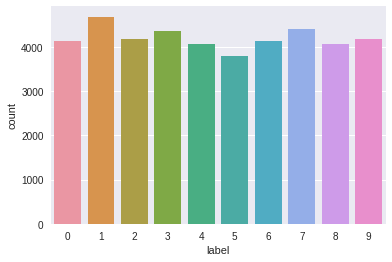

In [8]:
df = pd.read_csv('data/train.csv')
X, y = df[[col for col in df.columns if col != 'label']], df['label']

#Normalise Image Data
X = X/256

#Show data info
sns.countplot(y)
X.info()


###Undersample Data

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37950 entries, 0 to 37949
Columns: 784 entries, 0 to 783
dtypes: float64(784)
memory usage: 227.0 MB


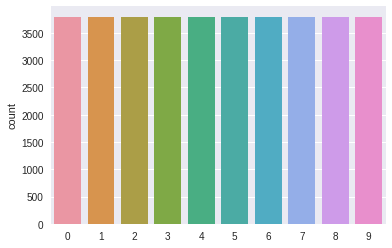

In [9]:
#Undersample data to balance class labels
rus = RandomUnderSampler(return_indices=True)
X, y, idx_resample = rus.fit_sample(X,y)

#Show data info
sns.countplot(y)
pd.DataFrame(X).info()

###View Data

5


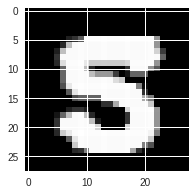

6


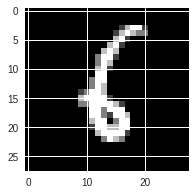

7


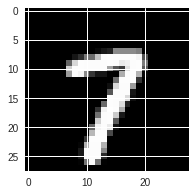

5


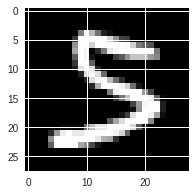

3


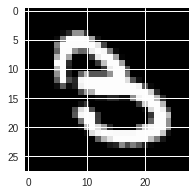

In [10]:
#Look at 5 random images
for i in range(0,5):
    idx = randint(0, len(y))
    print(y[idx])
    plt.figure(figsize=(3,3))
    plt.imshow(X[idx].reshape(28,28), cmap='gray')
    plt.show()

###Train Test Split
Threeway holdout with 5xCV will be used to tune models to have a strong generalisation accuracy.
Holdout/Unseen data will be used as a sanity check and for detailed comparison.


**Three-Way Holdout With KFold Cross Validation**

**M - Model, S-Settings**

<img src=https://www.lucidchart.com/publicSegments/view/5f2fb6b1-bf64-4aa7-8d91-bd9b34025379/image.jpeg width="750">




In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.9, test_size=0.1, 
                                                    stratify=y, shuffle=True)
del X; del y

##3. Hello Keras
Defining and compiling models with Keras; but interacting with them through the SKLearn package.

###Models and Search Space
Test a variety of architectures and configurations to find the models best suited to digit recognition.
Model performance can be very sensative to hyperparameter configuration. A Gridsearch allows for the selection of optimal models within a search space accounting for pairwise parameter interactions. Results are evaluated by model performance, train/predict speeds.



**Pairwise Interactions between parameters necesitate the use of broad search strategies.**

*Optimise parameters together, not seperately*

<img src=https://cdn-images-1.medium.com/max/1600/1*v-LBGd9GV0wZBJI3Vyqddw.jpeg width="500">


###Define Models and Architectural Parameters


In [0]:
#Single-Layer Perceptron
def SLP(input_shape, output_shape, lr=1e-3, callbacks=None):
    model = Sequential()
    model.add(Dense(units=output_shape, input_shape=input_shape,
                    use_bias=False,     activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=adam(lr=lr), 
                  metrics=['accuracy'])
    return model

#Multi-Layer Perceptron
def MLP(input_shape, output_shape, lr=1e-3, dropout_rate=0.0, callbacks=None):
    model = Sequential()
    model.add(Dense(units=64, input_shape=input_shape, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=output_shape, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam(lr=lr),
                  metrics=['accuracy'])
              
    return model
              
#Deep Feed Forward Nueral Network
def DFFNN(input_shape, output_shape, lr=1e-3, dropout_rate=0.0, callbacks=None):
    model = Sequential()
    model.add(Dense(units=64, input_shape=input_shape, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=output_shape, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=adam(lr=lr), 
                  metrics=['accuracy'])
    return model

#Convolutional Nueral Network
def CNN(input_shape, output_shape, lr=1e-3, dropout_rate=0.0, callbacks=None):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(16, 16), padding='same', input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(8, 8), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=adam(lr=lr), 
                  metrics=['accuracy'])
    return model

### Define Model Hyperparameter Search Space

**Some Constraints:**

1. Epochs : high enough that models learn until early stopping criteria,
     not so high that weak stragglers dominate train time.
2. Patience is is small enough that model exits quickly, large enough to traverse small plataues to local minima.
3. Batch: High enough for speed and stability, low enough for robust performance.
4. Learning Rater: High enough for train speed, small enough for tight convergence is posisble.
5. Dropout : High enough 
6. Activation: Relu is fast an appropriately non-linear.

In [0]:
# Define input shapes for architectures
flat_shape =  (CHANNELS*ROWS*COLS,)
image_shape = (CHANNELS, ROWS, COLS,)

# Output shape : number of classes for softmax layer
output_shape = num_classes

# list all build architectures to be explored
clfs = [SLP, MLP, DFFNN, CNN]

# Parameters requred to compile a model
build_params = set(["input_shape", "output_shape",'dropout_rate','lr'])

# Parameters called with the models "fit" method
fit_params = set(['epochs', 'batch_size', 'validation_split','shuffle','callbacks'])

# Adds Early stopping to clip diminishing returns from training
# Also prevents overfitting
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0.005, 
                           patience=1, verbose=0, mode='auto')]

#Similar settings for different architectures
param_grids= {
    'SLP': {
        "input_shape":[flat_shape],
        "output_shape":[output_shape],
        "epochs":[15],
        "batch_size":[256, 512],       
        "validation_split":[0.1],
        "shuffle":[True],
        "lr":[1e-3],
        "callbacks":[callbacks],
    },
    
    'MLP': {
        "input_shape":[flat_shape],
        "output_shape":[output_shape],
        "epochs":[15],
        "shuffle":[True],
        "batch_size":[256, 512],
        "validation_split":[0.1],
        'dropout_rate':[0.2, 0.3],
        "shuffle":[True],
        "lr":[1e-3],
        "callbacks":[callbacks],
    },
    
    'DFFNN' : {
        "input_shape":[flat_shape],
        "output_shape":[output_shape],
        "epochs":[15],
        "shuffle":[True],
        "batch_size":[256, 512],
        "validation_split":[0.1],
        "shuffle":[True],
        'dropout_rate':[0.2, 0.3],
        "lr":[1e-3],
        "callbacks":[callbacks],
    },
    'CNN' : {
        "input_shape":[image_shape],
        "output_shape":[output_shape],
        "epochs":[15],   
        "batch_size":[256, 512],
        "validation_split":[0.1],
        "shuffle":[True],
        'dropout_rate':[0.2, 0.3],
        "lr":[1e-3],
        "callbacks":[callbacks],
    }
}


In [14]:
%%time

results = {}

# Find top10 Classifiers in a gridsearch.
def topn(gridsearch, n):
  GS_df = pd.DataFrame(gridsearch.cv_results_)
  topn = GS_df.sort_values('mean_test_score',ascending=False).head(n)
  return topn

# running grid search for each classifier
for clf in clfs:
    clf_name = str(clf).split()[1]
    input_shape = param_grids[clf_name]['input_shape'][0]
    current_GS = GridSearchCV(KerasClassifier(build_fn=clf, verbose=0, ), 
                              param_grids[clf_name],
                              cv=grid_search_cv_folds,
                              verbose=1,
                              refit=False,
                              #n_jobs=-1,
                              return_train_score=True).fit(
        X_train.reshape(-1, *input_shape), y_train)
    
    # Limit results to the following columns
    filter_results = ['rank_test_score'  , 
                      'mean_train_score' , 'std_train_score',
                      'mean_test_score'  , 'std_test_score',
                      'mean_fit_time'    , 'std_fit_time', 
                      'mean_score_time'  , 'std_score_time',
                      'params',
                      ]
    
    top5 = topn(current_GS, 5)[filter_results]
    results[clf_name] = top5
    display(top5.round(3))
    print()

Fitting 8 folds for each of 2 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  1.7min finished


,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,1,0.919,0.001,0.913,0.003,6.882,0.300,0.039,0.002,"{'batch_size': 256, 'callbacks': [<keras.callb..."
1,2,0.913,0.002,0.907,0.005,5.010,0.281,0.027,0.001,"{'batch_size': 512, 'callbacks': [<keras.callb..."



Fitting 8 folds for each of 4 candidates, totalling 32 fits


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  4.2min finished


,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,1,0.968,0.004,0.956,0.005,8.292,1.097,0.043,0.001,"{'batch_size': 256, 'callbacks': [<keras.callb..."
1,2,0.966,0.003,0.954,0.004,9.044,0.817,0.044,0.001,"{'batch_size': 256, 'callbacks': [<keras.callb..."
2,3,0.962,0.003,0.951,0.006,6.366,0.482,0.029,0.001,"{'batch_size': 512, 'callbacks': [<keras.callb..."
3,4,0.958,0.005,0.949,0.005,6.591,0.833,0.029,0.001,"{'batch_size': 512, 'callbacks': [<keras.callb..."



Fitting 8 folds for each of 4 candidates, totalling 32 fits


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  5.3min finished


,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,1,0.969,0.003,0.955,0.002,9.585,0.795,0.048,0.001,"{'batch_size': 256, 'callbacks': [<keras.callb..."
2,2,0.966,0.002,0.954,0.003,8.465,0.477,0.031,0.001,"{'batch_size': 512, 'callbacks': [<keras.callb..."
1,3,0.962,0.004,0.950,0.003,10.608,1.008,0.049,0.001,"{'batch_size': 256, 'callbacks': [<keras.callb..."
3,4,0.962,0.004,0.950,0.003,9.687,0.924,0.033,0.001,"{'batch_size': 512, 'callbacks': [<keras.callb..."



Fitting 8 folds for each of 4 candidates, totalling 32 fits


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 10.4min finished


,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params
0,1,0.989,0.003,0.983,0.003,16.971,2.572,0.168,0.017,"{'batch_size': 256, 'callbacks': [<keras.callb..."
1,2,0.989,0.002,0.983,0.003,18.362,1.934,0.164,0.003,"{'batch_size': 256, 'callbacks': [<keras.callb..."
2,3,0.989,0.001,0.983,0.002,18.604,1.464,0.144,0.004,"{'batch_size': 512, 'callbacks': [<keras.callb..."
3,4,0.987,0.003,0.981,0.002,19.191,2.583,0.142,0.002,"{'batch_size': 512, 'callbacks': [<keras.callb..."



CPU times: user 19min 3s, sys: 4min, total: 23min 3s
Wall time: 21min 31s


###Select Paramameters
Choose desirable models and configurations for further testing.

In [15]:
# Unpack settings for best performers
top5_params = {k:v.params for k,v in results.items()}

# Settings with highest GridSearchCV test accuracy
selected_params = {k:{k2:[v2] for k2,v2 in v.params.values[0].items()} for k,v in results.items()}

# Custom settings from results table
# selected_params = {
#     'NearestCentroid':0
#     ...    
#}


print('Selected Params:')
for k,v in top5_params.items():
  print(k)
  display(pd.DataFrame(list(v)).head(1))
  print()

print('Top5 Params')
for k,v in top5_params.items():
  print(k)
  display(pd.DataFrame(list(v)))
  print()




Selected Params:
SLP


,batch_size,callbacks,epochs,input_shape,lr,output_shape,shuffle,validation_split
0,256,[<keras.callbacks.EarlyStopping object at 0x7f...,15,"(784,)",0.001,10,True,0.1



MLP


,batch_size,callbacks,dropout_rate,epochs,input_shape,lr,output_shape,shuffle,validation_split
0,256,[<keras.callbacks.EarlyStopping object at 0x7f...,0.2,15,"(784,)",0.001,10,True,0.1



DFFNN


,batch_size,callbacks,dropout_rate,epochs,input_shape,lr,output_shape,shuffle,validation_split
0,256,[<keras.callbacks.EarlyStopping object at 0x7f...,0.2,15,"(784,)",0.001,10,True,0.1



CNN


,batch_size,callbacks,dropout_rate,epochs,input_shape,lr,output_shape,shuffle,validation_split
0,256,[<keras.callbacks.EarlyStopping object at 0x7f...,0.2,15,"(1, 28, 28)",0.001,10,True,0.1



Top5 Params
SLP


,batch_size,callbacks,epochs,input_shape,lr,output_shape,shuffle,validation_split
0,256,[<keras.callbacks.EarlyStopping object at 0x7f...,15,"(784,)",0.001,10,True,0.1
1,512,[<keras.callbacks.EarlyStopping object at 0x7f...,15,"(784,)",0.001,10,True,0.1



MLP


,batch_size,callbacks,dropout_rate,epochs,input_shape,lr,output_shape,shuffle,validation_split
0,256,[<keras.callbacks.EarlyStopping object at 0x7f...,0.2,15,"(784,)",0.001,10,True,0.1
1,256,[<keras.callbacks.EarlyStopping object at 0x7f...,0.3,15,"(784,)",0.001,10,True,0.1
2,512,[<keras.callbacks.EarlyStopping object at 0x7f...,0.2,15,"(784,)",0.001,10,True,0.1
3,512,[<keras.callbacks.EarlyStopping object at 0x7f...,0.3,15,"(784,)",0.001,10,True,0.1



DFFNN


,batch_size,callbacks,dropout_rate,epochs,input_shape,lr,output_shape,shuffle,validation_split
0,256,[<keras.callbacks.EarlyStopping object at 0x7f...,0.2,15,"(784,)",0.001,10,True,0.1
1,512,[<keras.callbacks.EarlyStopping object at 0x7f...,0.2,15,"(784,)",0.001,10,True,0.1
2,256,[<keras.callbacks.EarlyStopping object at 0x7f...,0.3,15,"(784,)",0.001,10,True,0.1
3,512,[<keras.callbacks.EarlyStopping object at 0x7f...,0.3,15,"(784,)",0.001,10,True,0.1



CNN


,batch_size,callbacks,dropout_rate,epochs,input_shape,lr,output_shape,shuffle,validation_split
0,256,[<keras.callbacks.EarlyStopping object at 0x7f...,0.2,15,"(1, 28, 28)",0.001,10,True,0.1
1,256,[<keras.callbacks.EarlyStopping object at 0x7f...,0.3,15,"(1, 28, 28)",0.001,10,True,0.1
2,512,[<keras.callbacks.EarlyStopping object at 0x7f...,0.2,15,"(1, 28, 28)",0.001,10,True,0.1
3,512,[<keras.callbacks.EarlyStopping object at 0x7f...,0.3,15,"(1, 28, 28)",0.001,10,True,0.1


###10xCV Experiment
Use 10xCV as its a robust evaluation metric.

**The cross_val_score - problematic when using callbacks**

**GridSearchCV - more transparent and friendly with callbacks**


In [16]:
%%time

# 10xCV on sample data using selected params
cv_scores = []
for clf in clfs:
    clf_name = str(clf).split()[1]
    input_shape = param_grids[clf_name]['input_shape'][0]
    params = selected_params[clf_name]
    
    input_shape = param_grids[clf_name]['input_shape'][0]
    
    current_CV = GridSearchCV(KerasClassifier(build_fn=clf, verbose=0, ), 
                              params,
                              cv=cv_experiment_folds,
                              verbose=1,
                              refit=False,
                              #n_jobs=-1,
                              return_train_score=True).fit(
        X_train.reshape(-1, *input_shape), y_train)
    
    filter_results = [ 
                      'mean_train_score' , 'std_train_score',
                      'mean_test_score'  , 'std_test_score',
                      'mean_fit_time'    , 'std_fit_time', 
                      'mean_score_time'  , 'std_score_time',
                     ]

    
    top1 = topn(current_CV, 1)[filter_results]
    top1['classifier'] = clf_name
    cv_scores.append(top1)

cv_results = pd.concat(cv_scores, axis=0).round(3)

# print the avg CVx10 score.
# Do ranked cross val
#cv_results = pd.DataFrame(cv_scores, ['10xCV']).round(3).T
display(cv_results)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.4min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.7min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.7min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.8min finished


,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,classifier
0,0.919,0.003,0.912,0.003,13.935,0.785,0.043,0.001,SLP
0,0.969,0.002,0.956,0.003,15.860,0.723,0.045,0.001,MLP
0,0.968,0.004,0.954,0.005,15.911,1.161,0.049,0.001,DFFNN
0,0.989,0.004,0.984,0.003,21.476,3.233,0.144,0.008,CNN


CPU times: user 11min 16s, sys: 1min 26s, total: 12min 43s
Wall time: 11min 42s


### Learning Curves Experiment
Assess models capacities for further learning and evaluated bias/variance tradeoffs.
Models may be in a receding phase for its generalisationa accuracy; or near the "knee" of the curve where they could greatly benefit from more data.

![Learning Curve Signatures](https://sebastianraschka.com/images/faq/ml-solvable/bias-variance.png)








CPU times: user 22min 32s, sys: 1min 29s, total: 24min 2s
Wall time: 22min 57s


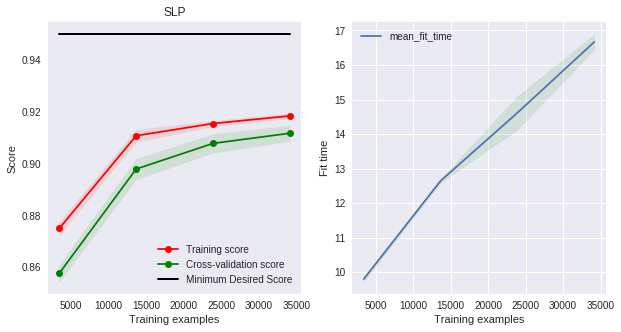

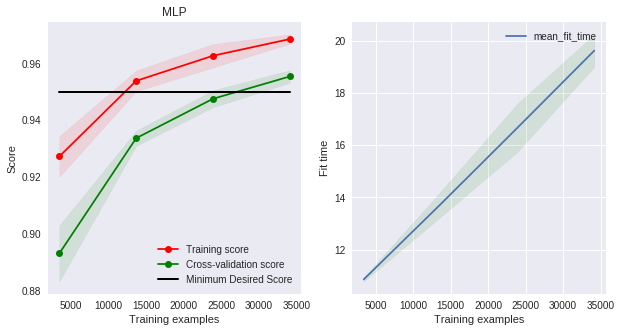

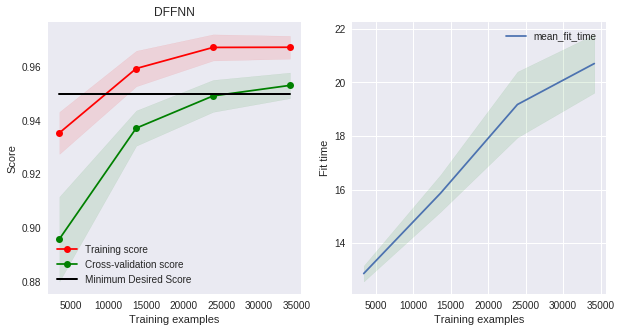

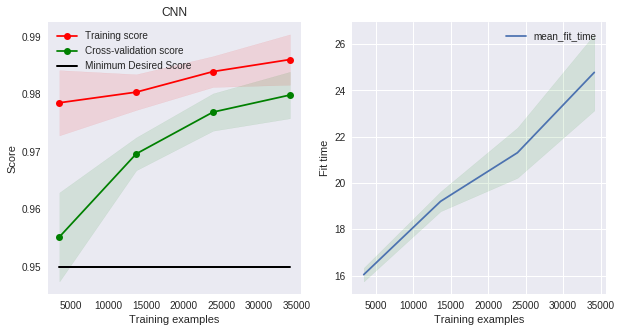

In [17]:
%%time

def data_curve_keras(estimator, X, y, cv=3, fit_params=None, n_jobs=1, train_sizes=np.linspace(.1,1.,5)):
  #return of DF of train size, train/test mean/stdev
  
  dfs = []
  for frac in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=frac, test_size=0)
    current_CV = GridSearchCV(estimator=estimator, 
                              param_grid=fit_params,
                              cv=cv,
                              verbose=0,
                              refit=False,
                              n_jobs=n_jobs,
                              return_train_score=True).fit(X_train, y_train)
    
    filter_results = ['mean_train_score' , 'std_train_score',
                      'mean_test_score'  , 'std_test_score',
                      'mean_fit_time'    , 'std_fit_time', 
                      'mean_score_time'  , 'std_score_time',
                      ]
    
    top1 = topn(current_CV, 1)[filter_results]
    top1['train_size'] = len(y_train)
    dfs.append(top1)
  
  results = pd.concat(dfs, axis=0)
  return results

def plot_learning_curve_keras(estimator, title, X, y, fit_params=None, ylim=None, cv=None,
                       n_jobs=1, train_sizes=np.linspace(.1,1.0,5), 
                       acc_threshold=0.95):
 
    #unpack plot data
    lc = data_curve_keras(
        estimator, X, y, 
        cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        fit_params=fit_params
    )
    
    train_sizes = lc.train_size
    train_std, test_std = lc.std_train_score, lc.std_test_score
    train_mean, test_mean = lc.mean_train_score, lc.mean_test_score
    fit_mean, fit_std = lc.mean_fit_time, lc.std_fit_time
    
    
    #plot Setup
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    plt.grid()
    
    #overlay std_dev on train curve
    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1, color="r")
    
    #overlay std_dev on validation curve
    plt.fill_between(train_sizes, test_mean - test_std,
                     test_mean + test_std, alpha=0.1, color="g")
    
    #plot train points
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    
    #plot validation points
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
    
    #plot accuracy threshold
    plt.plot(train_sizes, [0.95]*len(train_sizes), 'k-', lw=2, label="Minimum Desired Score")

    plt.legend(loc="best")
    
    
    plt.subplot(1, 2, 2)
    
    plt.xlabel('Training examples')
    plt.ylabel('Fit time')
    plt.plot(train_sizes, fit_mean)
    plt.fill_between(train_sizes, fit_mean - fit_std,
                                  fit_mean + fit_std, alpha=0.1,color="g")
    plt.legend(loc="best")

    
    #return plt
  


for clf in clfs:
  clf_name = str(clf).split()[1]
  clf_params = selected_params[clf_name]
  input_shape = param_grids[clf_name]['input_shape'][0]
  
  plot_learning_curve_keras(KerasClassifier(build_fn=clf, verbose=0, ), clf_name, 
                          X_train.reshape(-1, *input_shape), y_train, 
                          fit_params=clf_params,
                          cv=learning_curve_folds,
                          train_sizes=np.linspace(.1,0.99999,4)
                          )
 
  


###Holdout Experiment
Using holdout dataset

In [18]:
%%time

def pandas_classification_report(y_test, y_pred):
    #grab summary
    metrics_summary = precision_recall_fscore_support(y_test, y_pred)
    
    #grab avg
    avg = list(precision_recall_fscore_support(y_test, y_pred, 
                                               average='weighted'))

    #setup dataframe of cols<-labels, rows<-scores
    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)
    
    #sum support and assign it to average
    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    #add avg/total column
    class_report_df['avg / total'] = avg

    #transpose reusult cols<-scores, rows <- labels
    return class_report_df.T


holdout_scores={}
clf_reports={}
fitted_models = {}

y_train_wide = to_categorical(y_train, 10)

for clf in clfs:
  clf_name = str(clf).split()[1]
  all_params = selected_params[clf_name]
  all_params = {k:v[0] for k,v in all_params.items()}
  building_params = {k:v for k,v in all_params.items() if k in build_params}
  fitting_params = {k:v for k,v in all_params.items() if k in fit_params}
  input_shape = param_grids[clf_name]['input_shape'][0]
  
  model = clf(**building_params)
  history = model.fit(X_train.reshape(-1, *input_shape), 
                      y_train_wide, 
                      **fitting_params,
                      verbose=0)
  model.save(clf_name+'.h5')
  
  #Keras API to save model.
  fitted_models[clf_name] = [model, history]
  
  preds_wide = model.predict(X_test.reshape(-1, *input_shape))
  preds = preds_wide.argmax(axis=1)

  score = accuracy_score(preds, y_test)
  holdout_scores[clf_name] = score
  
  print(clf_name)
  clf_report = pandas_classification_report(y_test, preds) 
  clf_reports[clf_name] = clf_report
  display(clf_report.\
          round(3).\
          style.\
          bar(subset=['precision', 'recall', 'f1-score'], 
              align='left', 
              color='#5fba7d'))
  print()
  
  holdout_results = pd.DataFrame(holdout_scores, ['Holdout_Acc']).round(3).T

display(holdout_results)

  
  


SLP


,precision,recall,f1-score,support
0,0.946,0.963,0.954,380
1,0.951,0.961,0.955,380
2,0.938,0.879,0.908,380
3,0.892,0.868,0.88,380
4,0.934,0.924,0.929,380
5,0.847,0.847,0.847,379
6,0.933,0.96,0.947,379
7,0.908,0.942,0.925,379
8,0.86,0.858,0.859,379
9,0.895,0.902,0.899,379



MLP


,precision,recall,f1-score,support
0,0.949,0.976,0.962,380
1,0.969,0.974,0.971,380
2,0.975,0.924,0.949,380
3,0.917,0.958,0.937,380
4,0.962,0.934,0.948,380
5,0.943,0.91,0.926,379
6,0.956,0.976,0.966,379
7,0.916,0.974,0.944,379
8,0.946,0.916,0.93,379
9,0.933,0.918,0.926,379



DFFNN


,precision,recall,f1-score,support
0,0.979,0.982,0.98,380
1,0.984,0.974,0.979,380
2,0.96,0.937,0.948,380
3,0.937,0.934,0.935,380
4,0.953,0.958,0.955,380
5,0.935,0.942,0.938,379
6,0.961,0.982,0.971,379
7,0.932,0.976,0.954,379
8,0.957,0.937,0.947,379
9,0.957,0.931,0.944,379



CNN


,precision,recall,f1-score,support
0,0.979,0.992,0.986,380
1,0.997,0.974,0.985,380
2,0.974,0.968,0.971,380
3,0.954,0.989,0.972,380
4,0.992,0.974,0.983,380
5,0.979,0.963,0.971,379
6,0.989,0.979,0.984,379
7,0.976,0.979,0.978,379
8,0.984,0.966,0.975,379
9,0.954,0.992,0.973,379


,Holdout_Acc
CNN,0.978
DFFNN,0.955
MLP,0.946
SLP,0.910


CPU times: user 2min 36s, sys: 8.54 s, total: 2min 44s
Wall time: 2min 38s


###Best Vs. Rest
Compare all classifiers to "best" to analyse subtle performance differences for each class and their unique strengths.


In [19]:

#Best choice from 10xCV
best_guess = cv_results.set_index('classifier')['mean_test_score'].idxmax()
print(best_guess)

#Best choice from holdout
#best_guess = holdout_results['Holdout_Acc'].idxmax()

#Custom choice
#best_guess='MLPClassifier'
#Best choice from 10xCV


#Best choice from holdout
#Best_guess = holdout_results['Holdout_Acc'].idxmax()

#Custom choice
#best_guess='MLPClassifier'

best = clf_reports[best_guess]

print('Best 10xCV CLF:',best_guess, end='\n\n')
for name,report in clf_reports.items():
  if name==best_guess:
    continue
  print(name,'vs',best_guess)
  display((best - report).round(3).style.bar(
      subset=['precision', 'recall', 'f1-score'], 
      align='zero', 
      color=['#d65f5f', '#5fba7d']))
  print()

CNN
Best 10xCV CLF: CNN

SLP vs CNN


,precision,recall,f1-score,support
0,0.033,0.029,0.031,0
1,0.047,0.013,0.03,0
2,0.035,0.089,0.063,0
3,0.062,0.121,0.092,0
4,0.058,0.05,0.054,0
5,0.132,0.116,0.124,0
6,0.056,0.018,0.037,0
7,0.068,0.037,0.053,0
8,0.124,0.108,0.116,0
9,0.059,0.09,0.074,0



MLP vs CNN


,precision,recall,f1-score,support
0,0.03,0.016,0.023,0
1,0.029,0,0.014,0
2,-0.001,0.045,0.022,0
3,0.037,0.032,0.035,0
4,0.03,0.039,0.035,0
5,0.036,0.053,0.045,0
6,0.033,0.003,0.018,0
7,0.061,0.005,0.034,0
8,0.038,0.05,0.044,0
9,0.021,0.074,0.047,0



DFFNN vs CNN


,precision,recall,f1-score,support
0,0,0.011,0.005,0
1,0.013,0,0.007,0
2,0.014,0.032,0.023,0
3,0.018,0.055,0.036,0
4,0.039,0.016,0.027,0
5,0.044,0.021,0.033,0
6,0.028,-0.003,0.013,0
7,0.044,0.003,0.024,0
8,0.027,0.029,0.028,0
9,-0.002,0.061,0.029,0


##4. Hello Deployment

###Load Kaggle Data and Model
Kaggle evaluates submissions by supplying the user with unlabeled test data. Predictions on unseen data are evaluated by Kaggle and fedback to the user.


In [0]:
#Load test data
test = pd.read_csv('data/test.csv')

#Load best model
top_model = load_model(best_guess+'.h5')

#Get input shape for best model
input_shape = param_grids[best_guess]['input_shape'][0]

#Re-train with all data
#top_model.fit(X,y)

###Make Prediction File
Format submission to match kaggle specifications.

In [21]:
#predictions in 1 hot encoded format
preds_wide = top_model.predict(test.values.reshape(-1, *input_shape))

#predictions in decoded format
preds = preds_wide.argmax(axis=1)

#cast as dataframe
preds = pd.DataFrame(preds, columns=['Label'])

#Add Image IDs, and re-order columns
preds['ImageID'] = range(1,len(preds)+1)
preds = preds[['ImageID','Label']]

#Save as CSV
pd.DataFrame(preds).to_csv('digit_recognition_sub.csv', index=False)

#Verify Raw File
! head digit_recognition_sub.csv

ImageID,Label
1,2
2,0
3,9
4,9
5,3
6,7
7,0
8,3
9,0


###Download Prediction File

In [0]:
from google.colab import files

files.download('digit_recognition_sub.csv')
files.download(best_guess+'.h5')

###Upload Predictions
1. [Digit Recognizer Submission](https://www.kaggle.com/c/digit-recognizer/submit): Drag and drop digit_recognition_sub.csv from downloads folder into submission box.
2. Fill describe model and submission!
3. Submit; check out score on the LeaderBoard:
98%+

###Results
CNNs perform significantly better at digit recognition than more traditional Nueral Net architectures.
Deeper models allow more representational freedom, the SLPs performance is very similar to that of a logistic regression; as they are fundamentally the same.

CNNs and deeper architectures have steeper learning curves; indicating they could benefit from seeing more data.

In general smaller batch sizes yield improved accuracy.

Dropout rate should be tuned to each architecture, but has a significant impact on performance.

* CNNs are particularly well suited to learning image representations such as Digit Recognition in MNist.

In the next iteration; different CNN architectures are explored to to optimise performance. 


## 5. Hello Documentation

### Package Overview
The advantage with many open-source packages is that they are well supported and typically well documented and tested. The Google client has less clear documentation but has generally good support on Stack-OverFlow and in Colaboratory Tutorials.

[SKLearn](http://scikit-learn.org/stable/index.html) : A simple open source machine learning toolkit in Python.

[Kaggle](https://www.kaggle.com/) : Hosts the data sources that will be used.

[Kaggle API](https://github.com/Kaggle/kaggle-api/blob/master/README.md) : CLI to engage with Kaggle.

[Google Client API](https://developers.google.com/drive/v3/web/quickstart/python): Python REST API for Google Drives.

[Imbalanced Learn](http://contrib.scikit-learn.org/imbalanced-learn/stable/) :  Python package offering a number of re-sampling techniques commonly used in datasets showing strong between-class imbalance.

[Pandas](https://pandas.pydata.org/): Open source data analysis tools for Python

[Seaborn](https://seaborn.pydata.org/): Statistical data visualisation.

[NumPy](http://www.numpy.org/): High performing Python wrapper for C.

[Pandas.style](https://pandas.pydata.org/pandas-docs/stable/style.html): DataFrame styling and graphics in Pandas.